In [1]:
#imports
import pandas as pd
import numpy as np

#API 
import requests

#Automating
import time
import datetime
import warnings
import sys

#sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import plot_confusion_matrix

### Build API Function and Collect Data

>Let's write a function (from BH 9-12 )to scale up the previous process to pull many posts, working iteratively backwards using epoch timestamp.

In [2]:
def get_posts(subreddit, n_iter, epoch_right_now): # subreddit name and number of times function should run
    # store base url variable
    base_url = 'https://api.pushshift.io/reddit/search/submission/?subreddit='

    # instantiate empty list    
    df_list = []
    
    # save current epoch, used to iterate in reverse through time
    current_time = epoch_right_now
    
    # set up for loop
    for post in range(n_iter):
        
        # instantiate get request
        res = requests.get(
            
            # requests.get takes base_url and params
            base_url,
            
            # parameters for get request
            params = {
                
                # specify subreddit
                'subreddit' : subreddit,
                
                # specify number of posts to pull
                'size' : 100,
                
                # ???
                'lang' : True,
                
                # pull everything from current time backward
                'before' : current_time }
        )
        
        # take data from most recent request, store as df
        df = pd.DataFrame(res.json()['data'])
        
        # pull specific columns from dataframe for analysis
        df = df.loc[:, ['title',
                        'created_utc', 
                        'selftext',
                        'subreddit',
                        'author',
                        'media_only',
                        'permalink']]
        
        # append to empty dataframe list
        df_list.append(df)
        
        # add wait time
        time.sleep(30)
        
        # set current time counter back to last epoch in recently grabbed df
        current_time = df['created_utc'].min()

    # return one dataframe for all requests
    return pd.concat(df_list, axis=0)
# Adapated from Tim Book's Lesson Example

>1602021145 timestamp now
>
> Two subreddits I have chosen this time are : running, healthy


> Getting the posts (50 iterate everytime 100 posts, totally 5000 posts for each subreddit.)

In [3]:
#big_running_df=get_posts(subreddit=['running'], n_iter=100, epoch_right_now=1602190775)

In [9]:
#big_loseit_df=get_posts(subreddit=['loseit'], n_iter=100, epoch_right_now=1602190775)

In [10]:
big_running_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 99
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        10000 non-null  object
 1   created_utc  10000 non-null  int64 
 2   selftext     9943 non-null   object
 3   subreddit    10000 non-null  object
 4   author       10000 non-null  object
 5   media_only   10000 non-null  bool  
 6   permalink    10000 non-null  object
dtypes: bool(1), int64(1), object(5)
memory usage: 556.6+ KB


In [7]:
big_loseit_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4865 entries, 0 to 4864
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Unnamed: 0.1      4865 non-null   int64 
 1   Unnamed: 0.1.1    4865 non-null   int64 
 2   Unnamed: 0.1.1.1  4865 non-null   int64 
 3   title             4865 non-null   object
 4   created_utc       4865 non-null   int64 
 5   selftext          4865 non-null   object
 6   subreddit         4865 non-null   object
 7   author            4865 non-null   object
 8   media_only        4865 non-null   bool  
 9   permalink         4865 non-null   object
dtypes: bool(1), int64(4), object(5)
memory usage: 384.8+ KB


In [11]:
big_running_df['selftext'].value_counts()

[removed]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          1679
Hey runners, it's another day and it is time to post your accomplishments you'd like to share - big or small.\n\nNote: No need t

In [12]:
big_running_df.head(2)

,title,created_utc,selftext,subreddit,author,media_only,permalink
0,Ouch :(,1602190037,I’m sure that this has been posted here in the...,running,mid-southern,False,/r/running/comments/j7l6iy/ouch/
1,Mapping out a longer run in a populated suburb...,1602189910,"hey guys, I'm fairly new to running, have been...",running,ngomaam,False,/r/running/comments/j7l55d/mapping_out_a_longe...


In [13]:
#exporting to csv file
big_running_df.to_csv('./CSV files/big_running_df.csv')

In [14]:
big_running_df.drop_duplicates(subset='title', inplace=True)

In [15]:
big_loseit_df.drop_duplicates(subset='title', inplace=True)

In [16]:
big_loseit_df['selftext'].value_counts()

[removed]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

In [17]:
big_loseit_df.head(5)

,title,created_utc,selftext,subreddit,author,media_only,permalink
0,How do I know what a good goal weight is?,1602190682,[removed],loseit,normalicide,False,/r/loseit/comments/j7lddq/how_do_i_know_what_a...
1,How do I know what my goal weight should be?,1602189715,[removed],loseit,normalicide,False,/r/loseit/comments/j7l2yc/how_do_i_know_what_m...
2,Someone made a rude comment and my only soluti...,1602188647,[removed],loseit,samthes,False,/r/loseit/comments/j7kr57/someone_made_a_rude_...
3,I’ve Been a Fat Girl Most of My Life. Through ...,1602188349,[removed],loseit,bully_supporter,False,/r/loseit/comments/j7knxc/ive_been_a_fat_girl_...
4,Weight Gain From SSRIs,1602188333,[removed],loseit,throwaway12182058,False,/r/loseit/comments/j7knra/weight_gain_from_ssris/


In [18]:
#exporting to csv file
big_loseit_df.to_csv('./CSV files/big_loseit_df.csv')

In [19]:
big_running_df=pd.read_csv('./CSV files/big_running_df.csv', keep_default_na=False, index_col=0)

In [20]:
big_loseit_df=pd.read_csv('./CSV files/big_loseit_df.csv', keep_default_na=False, index_col=0)

In [21]:
# creating the target value
big_loseit_df['running']=0
big_running_df['running']=1

In [23]:
#Merging two dataframes

big_df=big_running_df.append(big_loseit_df, sort=True)
big_df.drop(columns=['permalink'], inplace=True)

In [24]:
#let's export it to csv and then examine it
big_df.to_csv('./CSV files/big_df_loseit_running.csv')

In [25]:
big_df.tail(3)

,author,created_utc,media_only,running,selftext,subreddit,title
97,determinedpeach,1597018927,False,0,[removed],loseit,LPT: If you chug water and then take a gulp of...
98,thr_owo_,1597018805,False,0,Just wanted to share a huge mental milestone i...,loseit,"Milestone: I had my first ""treat"" day today wi..."
99,AspiringPervertPoet,1597018722,False,0,F26 SW 218 CW 186 GW 170 final GW 144\n\nI've ...,loseit,Milestone: I weigh less than my boyfriend!


In [26]:
#Getting 3 columns of author and is_motivating and title and making author is the index column
big_df= big_df[['running', 'title', 'author']]
big_df.set_index('author', inplace=True)
big_df

,running,title
author,,
mid-southern,1,Ouch :(
ngomaam,1,Mapping out a longer run in a populated suburb...
Prestigious_Rub2216,1,𝓈𝓉𝑜𝒸𝓀𝑜𝓁𝑜𝓈 𝒷𝑒𝒶𝓉𝓈
The_Way_Life_Goes,1,Advice on Transitioning to Minimalist/Low Drop...
lanky-smoove,1,Yesterday’s run; Not even out of breath but my...
...,...,...
tiredINFJ-T,0,Hi everyone!! I (F21) have recently started my...
onajourney314,0,How can I stop being a fat lazy piece of shit ...
determinedpeach,0,LPT: If you chug water and then take a gulp of...


In [27]:
big_df.index.unique()

Index(['mid-southern', 'ngomaam', 'Prestigious_Rub2216', 'The_Way_Life_Goes',
       'lanky-smoove', 'thehansolo7', 'TheAllmightyRoblox', 'still_killing_it',
       'AmbitiousRunner', 'smooner1993',
       ...
       'InfinityStyle', 'NefariousSerendipity', 'ejb8705', 'fivepasttwo',
       'themasterofallthngs', 'tiredINFJ-T', 'onajourney314',
       'determinedpeach', 'thr_owo_', 'AspiringPervertPoet'],
      dtype='object', name='author', length=14689)

In [28]:
big_df.isnull().sum()

running    0
title      0
dtype: int64

In [29]:
big_df.describe().T

,count,mean,std,min,25%,50%,75%,max
running,19611.0,0.509918,0.499914,0.0,0.0,1.0,1.0,1.0


In [30]:
big_df['running'].nunique()

2

### Word/Tag Cloud
>
>Tags are usually single words, and the importance of each tag is shown with font size or color.

In [31]:
#https://peekaboo-vision.blogspot.com/2012/11/a-wordcloud-in-python.html
from wordcloud import WordCloud, get_single_color_func, ImageColorGenerator, STOPWORDS
from nltk.corpus import stopwords
#stopwords= set(STOPWORDS)
stopWordsListEng = stopwords.words("english")
Minoo_new_stopwords_to_add = ['Michael', 'turkey', 'Ronnie', 'dtype', 'DD', '1t']
stopwords= stopWordsListEng.extend(Minoo_new_stopwords_to_add)


def show_wordcloud(data, title=None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=500,
        max_font_size=70, 
        scale=5,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(15, 15))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=3)

    plt.imshow(wordcloud)
    plt.show()

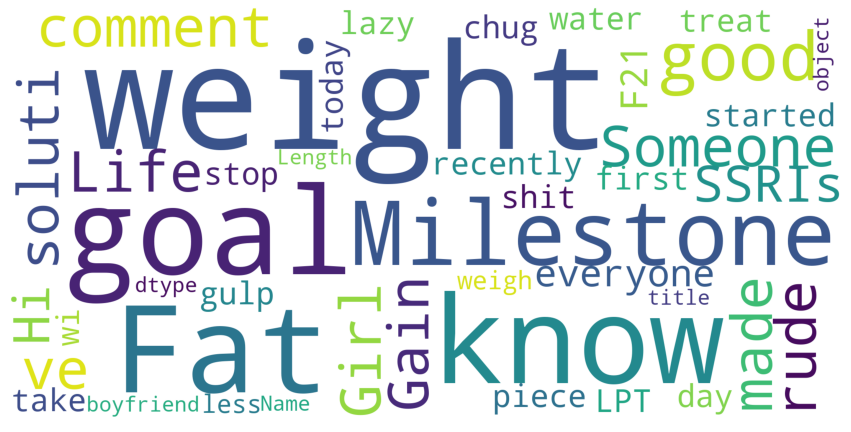

In [32]:
import matplotlib.pyplot as plt
#let's get the word cloud for healthy df
show_wordcloud(big_loseit_df['title'])

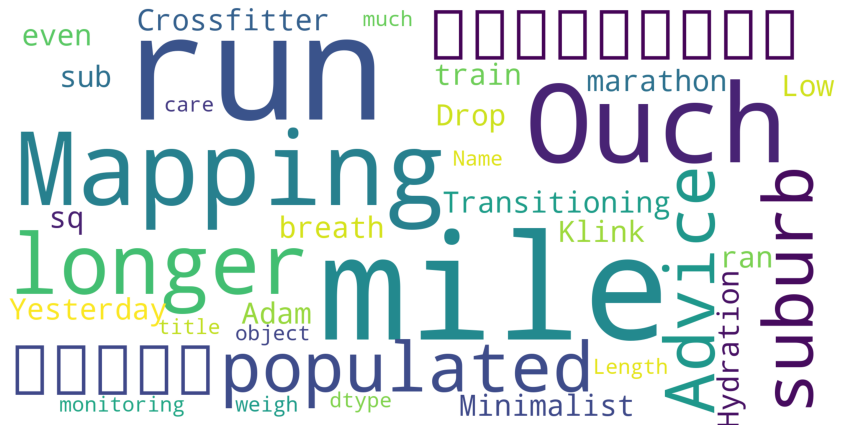

In [33]:
#let's get the word cloud for running df
show_wordcloud(big_running_df['title'])

### Modeling Data
>Train/Test split

In [34]:
big_df.reset_index(drop=True, inplace=True)

In [35]:
big_df

,running,title
0,1,Ouch :(
1,1,Mapping out a longer run in a populated suburb...
2,1,𝓈𝓉𝑜𝒸𝓀𝑜𝓁𝑜𝓈 𝒷𝑒𝒶𝓉𝓈
3,1,Advice on Transitioning to Minimalist/Low Drop...
4,1,Yesterday’s run; Not even out of breath but my...
...,...,...
19606,0,Hi everyone!! I (F21) have recently started my...
19607,0,How can I stop being a fat lazy piece of shit ...
19608,0,LPT: If you chug water and then take a gulp of...
19609,0,"Milestone: I had my first ""treat"" day today wi..."


In [36]:
X=big_df['title']

In [37]:
y=big_df['running']

In [38]:
# checking balance of data and baseline accuracy
#the results seems like the data set is in balance!
big_df['running'].value_counts(normalize=True)

1    0.509918
0    0.490082
Name: running, dtype: float64

In [39]:
X_train, X_test, y_train, y_test=train_test_split(X, y, random_state=28, stratify=y)

In [40]:
X_train.shape

(14708,)

In [41]:
y_train

9625     1
255      1
13305    0
5741     1
7556     1
        ..
18800    0
16275    0
1540     1
7625     1
690      1
Name: running, Length: 14708, dtype: int64


### Preprocessing
> Fitting a count vectorizer to find the most popular words


In [42]:
## Adding more letters and words to stopwords as below:
import nltk
minoo_stopwords = nltk.corpus.stopwords.words('english')
new_words=("`","’","n't", "thi", "anyon", "'m", "`m", "’m", "loss")
for i in new_words:
    minoo_stopwords.append(i)

# get this code from http://jonathansoma.com/lede/algorithms-2017/classes/more-text-analysis/counting-and-stemming/
from textblob import TextBlob

# Use TextBlob
def textblob_tokenizer(str_input):
    blob = TextBlob(str_input.lower())
    tokens = blob.words
    words = [token.stem() for token in tokens]
    return words

In [122]:
#The result for using porterstemmer was not good! the letters like "m" and "t" and "-" were in most common words.
 #Use NLTK's PorterStemmer
from nltk.stem import PorterStemmer
import re
def stemming_tokenizer(str_input):
    words = re.sub(r"[^A-Za-z0-9\-]", " ", str_input).lower().split()
    words = [PorterStemmer.stem(words,word) for word in words]
    return words

In [124]:
#instantiate and fit and transform our model on CountVectorizer
cvec=CountVectorizer(
        analyzer='word',
        tokenizer=textblob_tokenizer,
        preprocessor= None,
        stop_words=minoo_stopwords)

X_train_cvec=cvec.fit_transform(X_train)
X_test_cvec=cvec.transform(X_test)
X_train_cvec

<14708x7529 sparse matrix of type '<class 'numpy.int64'>'
	with 79029 stored elements in Compressed Sparse Row format>

In [45]:
#visualizing our train data set
cvec_df= pd.DataFrame(X_train_cvec.todense(),
                     columns=cvec.get_feature_names())

cvec_df

,'acceler,'apron,'bone,'bulk,'click,'cold,'comfort,'convers,'curv,'d,...,🙏,🙏🏻,🙏🏼,🤔,🤗,🤡,🤷‍♂️,🥰,🥳,🥺
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14703,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14704,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14705,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14706,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [46]:
columns=cvec.get_feature_names()
columns

["'acceler",
 "'apron",
 "'bone",
 "'bulk",
 "'click",
 "'cold",
 "'comfort",
 "'convers",
 "'curv",
 "'d",
 "'diet",
 "'easi",
 "'fad",
 "'jogger",
 "'le",
 "'ll",
 "'m",
 "'marathon",
 "'minimalist",
 "'overweight",
 "'process",
 "'put",
 "'re",
 "'right",
 "'run",
 "'runner",
 "'s",
 "'secret",
 "'silent",
 "'sore",
 "'ten",
 "'thi",
 "'ve",
 "'walk",
 '0',
 '0-5k',
 '0.4',
 '0.7',
 '0/178lb',
 '00:31:49',
 '00:34:10',
 '01',
 '02',
 '03',
 '03:40min',
 '04',
 '05',
 '06',
 '07',
 '08',
 '09',
 '09/01/2001',
 '09/04/2020',
 '0|171lb',
 '1',
 '1+yr',
 '1,000',
 '1,000,000',
 '1,200',
 '1,200/day',
 '1,300',
 '1,3kg',
 '1,5',
 '1,500',
 '1,700',
 '1-2',
 '1-2x',
 '1.2',
 '1.2lb',
 '1.2m',
 '1.4',
 '1.4kg',
 '1.5',
 '1.5-2',
 '1.59.26',
 '1.5km',
 '1.5m',
 '1.5mile',
 '1.67',
 '1/2',
 '1/2lb',
 '1/3',
 '1/4th',
 '1/5',
 '10',
 '10,000',
 '10,271',
 '10-10',
 '10-12km',
 '10-15',
 '10-30',
 '10-day',
 '10-minut',
 '10.2kg',
 '10.5',
 '10.5lb',
 '10.6lb',
 '10.8',
 '100',
 '100,000',
 '1

In [47]:
X_train_cvec.todense()


matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])

In [48]:
X_train_cvec

<14708x7529 sparse matrix of type '<class 'numpy.int64'>'
	with 79029 stored elements in Compressed Sparse Row format>

In [49]:
y_train

9625     1
255      1
13305    0
5741     1
7556     1
        ..
18800    0
16275    0
1540     1
7625     1
690      1
Name: running, Length: 14708, dtype: int64

In [50]:
big_df


,running,title
0,1,Ouch :(
1,1,Mapping out a longer run in a populated suburb...
2,1,𝓈𝓉𝑜𝒸𝓀𝑜𝓁𝑜𝓈 𝒷𝑒𝒶𝓉𝓈
3,1,Advice on Transitioning to Minimalist/Low Drop...
4,1,Yesterday’s run; Not even out of breath but my...
...,...,...
19606,0,Hi everyone!! I (F21) have recently started my...
19607,0,How can I stop being a fat lazy piece of shit ...
19608,0,LPT: If you chug water and then take a gulp of...
19609,0,"Milestone: I had my first ""treat"" day today wi..."


In [51]:
X_train

9625                                        Ideal weight ?
255      Looking for advice from those who have ran a s...
13305    Advice on improving loose skin non-surgically?...
5741                     What should I eat before running?
7556              How often do I have to buy new sneakers?
                               ...                        
18800                                 SV-Lowest weight yet
16275                           Lose Skin After Weightloss
1540     Muscular distance runners with a BMI in the no...
7625                              HR for recovery workouts
690        Looking for merino zip hoodie. Any suggestions?
Name: title, Length: 14708, dtype: object

In [52]:
X_train.index

Int64Index([ 9625,   255, 13305,  5741,  7556, 18623, 15635,  2627, 17162,
             5164,
            ...
            10881,  1345, 18098, 11403,   121, 18800, 16275,  1540,  7625,
              690],
           dtype='int64', length=14708)

In [53]:
loseit_vect=pd.DataFrame(X_train_cvec.todense(),
                        columns=cvec.get_feature_names(), index=X_train.index).reindex(y_train[y_train == 0].index)

In [54]:
top_loseit_words= loseit_vect.mean().sort_values(ascending=False).iloc[:15]
top_loseit_words.values

array([0.22960599, 0.13332408, 0.08254717, 0.06603774, 0.06409545,
       0.05896226, 0.05743618, 0.0563263 , 0.0559101 , 0.05174806,
       0.0431465 , 0.04286903, 0.0427303 , 0.03787458, 0.03773585])

In [55]:
top_loseit_words=top_loseit_words.sort_values(ascending=False)
top_loseit_words

weight    0.229606
lose      0.133324
loss      0.082547
help      0.066038
day       0.064095
start     0.058962
need      0.057436
calori    0.056326
eat       0.055910
lost      0.051748
fat       0.043147
feel      0.042869
get       0.042730
lb        0.037875
'm        0.037736
dtype: float64

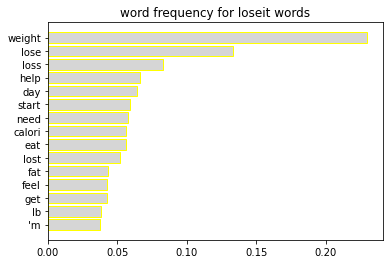

In [56]:
top_loseit_words=top_loseit_words.sort_values(ascending=True)
plt.barh(top_loseit_words.index, top_loseit_words.values, color=(0.2, 0.2, 0.2, 0.2),  edgecolor='Yellow')
plt.title('word frequency for loseit words');

>Plot for RUNNING df words

In [57]:
running_vect=pd.DataFrame(X_train_cvec.todense(),
                        columns=cvec.get_feature_names(), index=X_train.index).reindex(y_train[y_train == 1].index)
top_running_words= running_vect.mean().sort_values(ascending=False).iloc[:15]
top_running_words.values

array([0.42866667, 0.06373333, 0.05293333, 0.05226667, 0.05093333,
       0.04973333, 0.0484    , 0.0456    , 0.0424    , 0.04066667,
       0.04066667, 0.03946667, 0.036     , 0.0352    , 0.0336    ])

In [58]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

In [59]:
top_running_words=top_running_words.sort_values(ascending=False)
top_running_words

run         0.428667
shoe        0.063733
runner      0.052933
first       0.052267
marathon    0.050933
train       0.049733
get         0.048400
time        0.045600
mile        0.042400
advic       0.040667
pain        0.040667
help        0.039467
5k          0.036000
ani         0.035200
need        0.033600
dtype: float64

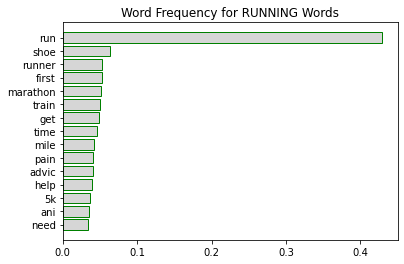

In [60]:
top_running_words=top_running_words.sort_values(ascending=True)
plt.barh(top_running_words.index, top_running_words.values, color=(0.2, 0.2, 0.2, 0.2),  edgecolor='Green')
plt.title('Word Frequency for RUNNING Words');


### Let's fit the model!
>Using Logistic Regression, Random Forest, TF-IDF and GridSearchCV

### Preprocessing: TF-IDF Tool (term frequency–inverse document frequency)


> Trying to do stemming and tokenizing 

In [61]:
import warnings
warnings.simplefilter("ignore", UserWarning)

In [62]:
# get this code from http://jonathansoma.com/lede/algorithms-2017/classes/more-text-analysis/counting-and-stemming/
## Adding more letters and words to stopwords as below:
import nltk
minoo_stopwords = nltk.corpus.stopwords.words('english')
new_words=("`","’","n't", "thi", "anyon")
for i in new_words:
    minoo_stopwords.append(i)

# get this code from http://jonathansoma.com/lede/algorithms-2017/classes/more-text-analysis/counting-and-stemming/
from textblob import TextBlob

# Use TextBlob
def textblob_tokenizer(str_input):
    blob = TextBlob(str_input.lower())
    tokens = blob.words
    words = [token.stem() for token in tokens]
    return words

In [63]:
#Instantiating and fitting the TF-IDF model
tvec= TfidfVectorizer(analyzer='word',
                     tokenizer=textblob_tokenizer,
                     preprocessor=None,
                     stop_words=minoo_stopwords)

X_train_tvec=tvec.fit_transform(X_train)
X_test_tvec=tvec.transform(X_test)
X_train_tvec

<14708x7529 sparse matrix of type '<class 'numpy.float64'>'
	with 79029 stored elements in Compressed Sparse Row format>

In [64]:
tvec_df= pd.DataFrame(X_train_tvec.todense(),
                     columns=tvec.get_feature_names())

tvec_df.head()

,'acceler,'apron,'bone,'bulk,'click,'cold,'comfort,'convers,'curv,'d,...,🙏,🙏🏻,🙏🏼,🤔,🤗,🤡,🤷‍♂️,🥰,🥳,🥺
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 1- Modeling: Logistic Regression and TFIDF Model

In [65]:
lr_tvec_model=LogisticRegression()

lr_tvec_model.fit(X_train_tvec, y_train)

print(f'Logistic Regression and TFIDF Model Score on Training Set :{lr_tvec_model.score(X_train_tvec, y_train)}')
print(f'Logistic Regression and TFIDF Model Score on Testing Set :{lr_tvec_model.score(X_test_tvec, y_test)}')

Logistic Regression and TFIDF Model Score on Training Set :0.9502991569214033
Logistic Regression and TFIDF Model Score on Testing Set :0.9127065062206812


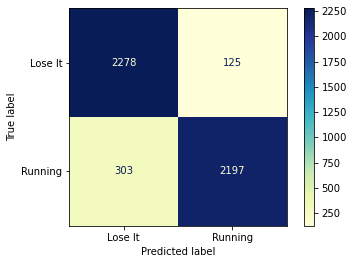

In [66]:
plot_confusion_matrix(lr_tvec_model, X_test_tvec, y_test, cmap='YlGnBu', display_labels=['Lose It', 'Running']);

In [68]:
#let's get the coefficients and find the top 10 coefficients and plot them!
X_df=pd.DataFrame(X_train_tvec.sum(), index=tvec.get_feature_names(), columns=['count'])
X_df['coef']=lr_tvec_model.coef_.T

In [69]:
#let's see if we have any null values...
X_df.isnull().sum()

count    0
coef     0
dtype: int64

In [74]:
top_10_coef=X_df.sort_values(by=['coef'], ascending=False).abs()
top_10_coef_sorted=top_10_coef.sort_values(by=['coef'], ascending=False).head(20)
top_10_coef_sorted


,count,coef
run,31604.818002,16.436660
runner,31604.818002,7.095513
weight,31604.818002,6.333865
shoe,31604.818002,5.625776
marathon,31604.818002,5.364755
nsv,31604.818002,5.233401
5k,31604.818002,4.939689
mile,31604.818002,4.924102
lose,31604.818002,4.870705
train,31604.818002,4.731543


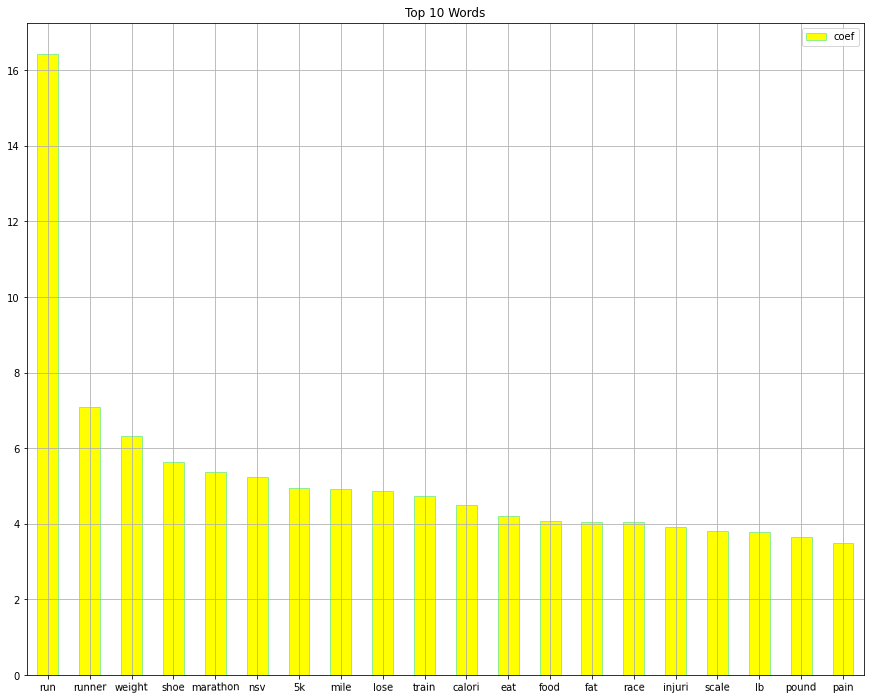

In [71]:
top_10_coef_sorted['coef'].plot.bar(
                        rot = 1, 
                        figsize=(15,12),
                        grid=True,
                        legend=True,
                        fontsize=10,
                        title="Top 10 Words",
                        color='Yellow',  
                        edgecolor='Lightgreen');

### 2- Modeling: Naive Bayes and TFIDF Model

In [72]:
nbayes_tvec_model=MultinomialNB()

nbayes_tvec_model.fit(X_train_tvec, y_train)

print(f'Naive Bayes and TFIDF Model Score on Training Set :{nbayes_tvec_model.score(X_train_tvec, y_train)}')
print(f'Logistic Regression and TFIDF Model Score on Testing Set :{nbayes_tvec_model.score(X_test_tvec, y_test)}')

Naive Bayes and TFIDF Model Score on Training Set :0.9389447919499592
Logistic Regression and TFIDF Model Score on Testing Set :0.910055068325515


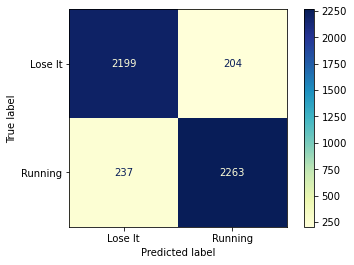

In [75]:
plot_confusion_matrix(nbayes_tvec_model, X_test_tvec, y_test, cmap='YlGnBu', display_labels=['Lose It', 'Running']);

### Preprocessing: Count Vectorizer tool

In [76]:
cvec=CountVectorizer(stop_words=minoo_stopwords, ngram_range=[1, 4])

In [77]:
X_train_cvec=cvec.fit_transform(X_train)

In [78]:
X_test_cvec=cvec.transform(X_test)

In [79]:
cvec_df= pd.DataFrame(X_train_cvec.todense(),
                     columns=cvec.get_feature_names())

cvec_df.head()

,00,00 31,00 31 49,00 34,00 34 10,00 34 10 time,00 5k,00 5k advice,00 5k average,00 5k average age,...,разгадать на,разгадать на чем,разгадать на чем работает,чем,чем работает,чем работает моя,чем работает моя знакомая,𝒷𝑒𝒶𝓉𝓈,𝓈𝓉𝑜𝒸𝓀𝑜𝓁𝑜𝓈,𝓈𝓉𝑜𝒸𝓀𝑜𝓁𝑜𝓈 𝒷𝑒𝒶𝓉𝓈
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 3- Modeling: Logistic Regression and CountVectorizer Model

In [80]:
lr_cvec_model=LogisticRegression()

lr_cvec_model.fit(X_train_cvec, y_train)

print(f'Logistic Regression and CountVectorizer Model Score on Training Set :{lr_cvec_model.score(X_train_cvec, y_train)}')
print(f'Logistic Regression and CountVectorizer Model Score on Testing Set :{lr_cvec_model.score(X_test_cvec, y_test)}')

Logistic Regression and CountVectorizer Model Score on Training Set :0.9873538210497689
Logistic Regression and CountVectorizer Model Score on Testing Set :0.92004894962268


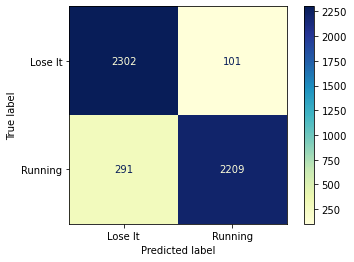

In [81]:
plot_confusion_matrix(lr_cvec_model, X_test_cvec, y_test, cmap='YlGnBu', display_labels=['Lose It', 'Running']);

### 4- Modeling: Naive Bayes and CountVectorizer Model

In [82]:
nbayes_cvec_model=MultinomialNB()

nbayes_cvec_model.fit(X_train_cvec, y_train)

print(f'Naive Bayes and cvec Model Score on Training Set :{nbayes_cvec_model.score(X_train_cvec, y_train)}')
print(f'Logistic Regression and cvec Model Score on Testing Set :{nbayes_cvec_model.score(X_test_cvec, y_test)}')

Naive Bayes and cvec Model Score on Training Set :0.9778351917323905
Logistic Regression and cvec Model Score on Testing Set :0.9253518254130124


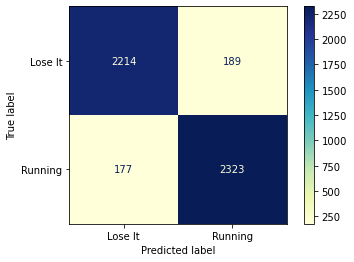

In [83]:
plot_confusion_matrix(nbayes_cvec_model, X_test_cvec, y_test, cmap='YlGnBu', display_labels=['Lose It', 'Running']);

### Let's initiate and fit the model through GridSearchCV and Pipe

In [84]:
nbayes=MultinomialNB()
pipe=make_pipeline(tvec, nbayes)
pipe

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...],
                                 tokenizer=<function textblob_tokenizer at 0x7ff9e8ab6670>)),
                ('multinomialnb', MultinomialNB())])

In [85]:
params={
       'tfidfvectorizer__max_features': [2000, 3000, 4000, 5000], 
          'tfidfvectorizer__stop_words': [minoo_stopwords, None],
         'tfidfvectorizer__ngram_range': [(1, 2), (1, 1)]
    
}

In [86]:
#grid
grid=GridSearchCV(pipe, param_grid=params)
#fit it
grid.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('tfidfvectorizer',
                                        TfidfVectorizer(stop_words=['i', 'me',
                                                                    'my',
                                                                    'myself',
                                                                    'we', 'our',
                                                                    'ours',
                                                                    'ourselves',
                                                                    'you',
                                                                    "you're",
                                                                    "you've",
                                                                    "you'll",
                                                                    "you'd",
                                                                    'your',
          

In [320]:
# Score model on training and testing set.
print(f'Grid model score on training data: {grid.score(X_train, y_train)}')
print(f'Grid model score on training data: {grid.score(X_test, y_test)}')

Grid model score on training data: 0.9442843419788665
Grid model score on training data: 0.9065459036640593


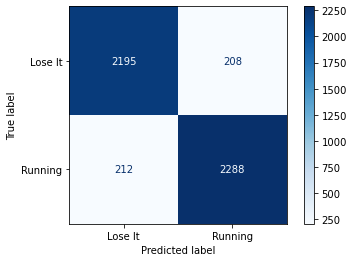

In [87]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
# Get predictions
preds = grid.predict(X_test)
# Save confusion matrix values
cmat2 = confusion_matrix(y_test, preds)
plot_confusion_matrix(grid,  X_test, y_test,cmap='Blues', display_labels=['Lose It', 'Running']);

### 5- Let's try Random Forest Classifier Model 

In [88]:
#Instantiating and fitting the Ranfom Forest Classifier model
rfc=RandomForestClassifier()

params={
    'n_estimators': [50, 100, 150, 200],
    
}

rfc_gs=GridSearchCV(estimator=rfc,
                   param_grid=params,
                   cv=5,
                   verbose=1,
                   n_jobs=-1)

rfc_gs= rfc_gs.fit(X_train_tvec, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  20 | elapsed:   57.5s remaining:    6.4s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   57.6s finished


In [89]:
print(f'Random Forest GridSearchCV Best Score:{rfc_gs.best_score_}')
print(f'Random Forest GridSearchCV Best Parameters:{rfc_gs.best_params_}')

Random Forest GridSearchCV Best Score:0.9076019870505622
Random Forest GridSearchCV Best Parameters:{'n_estimators': 100}


In [90]:
rfc_gs.best_estimator_.feature_importances_

array([1.46934109e-06, 2.76321226e-09, 1.83346545e-07, ...,
       4.11285645e-08, 1.05398249e-05, 2.09732000e-05])

In [91]:
# Let's find the importance for each word
word_importance=zip(tvec.get_feature_names(), rfc_gs.best_estimator_.feature_importances_);
sorted(word_importance, key=lambda x: abs(x[1]), reverse=True)


[('run', 0.14164872560436922),
 ('weight', 0.04512098886429054),
 ('lose', 0.025885006128981185),
 ('shoe', 0.017833432092798567),
 ('runner', 0.01646200875442707),
 ('loss', 0.014496293343847133),
 ('eat', 0.012717255938469722),
 ('calori', 0.012199092100114498),
 ('marathon', 0.01210061331126789),
 ('train', 0.011799764249608685),
 ('mile', 0.010378918673665),
 ('5k', 0.01012612454616183),
 ('lost', 0.009829291033835412),
 ('fat', 0.008911344057492237),
 ('pain', 0.008906528835060106),
 ('diet', 0.007900041390810625),
 ('nsv', 0.007625492638357085),
 ('pound', 0.007035572569619549),
 ('food', 0.006992657472803672),
 ('lb', 0.006599487400907148),
 ('race', 0.006280460440321005),
 ('injuri', 0.005793397268101795),
 ('ran', 0.005761805162564657),
 ('scale', 0.005129601883302802),
 ('knee', 0.004601600980500252),
 ('help', 0.004254605598624107),
 ('shin', 0.00414447897321497),
 ('start', 0.004138739823370947),
 ('plateau', 0.004117978382331931),
 ('journey', 0.004104807670428589),
 ('202

In [92]:
predict=rfc_gs.predict(X_test_tvec)
rfc_gs.score(X_test_tvec, y_test)

0.9059759331021824

In [93]:
predict

array([1, 1, 1, ..., 1, 0, 0])

### My Random Forest Model has the training score of %90 and testing score of 90%.

### 6- Let's try more pipelines for Logistic regression and TFIDF, CountVectorizer tools.

> Logistic Regression Model and TFIDFVectorizer tool

In [94]:
pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('lr', LogisticRegression())
])

pipe.fit(X_train, y_train)

# Evaluate how your model will perform on unseen data
print(f' Cross_val_score is: {cross_val_score(pipe, X_train, y_train, cv=3).mean()}') 
# Training score
print(f' Training Score is: {pipe.score(X_train, y_train)}')
# Test score
print(f' Test Score is: {pipe.score(X_test, y_test)}')

 Cross_val_score is: 0.909504887126312
 Training Score is: 0.9523388632036986
 Test Score is: 0.9206608199061799


> Logistic Regression Model and CountVectorizer tool

In [95]:
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('lr', LogisticRegression())
])

pipe.fit(X_train, y_train)

# Evaluate how your model will perform on unseen data
print(f' Cross_val_score is: {cross_val_score(pipe, X_train, y_train, cv=3).mean()}') 
# Training score
print(f' Training Score is: {pipe.score(X_train, y_train)}')
# Test score
print(f' Test Score is: {pipe.score(X_test, y_test)}')

 Cross_val_score is: 0.9106607669267954
 Training Score is: 0.9635572477563231
 Test Score is: 0.9208647766673466


> GridSearchCV and pipe 

In [96]:
pipe_params = {
    'cvec__max_features': [2500, 3000, 3500, 10_000],
    'cvec__min_df': [2, 3],
    'cvec__max_df': [.9, .95],
    'cvec__ngram_range': [(1,1), (1,2)]
}
gs = GridSearchCV(pipe, param_grid=pipe_params, cv=3)
gs.fit(X_train, y_train)
print(gs.best_score_)
gs.best_params_

0.9084851171894276


{'cvec__max_df': 0.9,
 'cvec__max_features': 3500,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 1)}

In [97]:
print(f'GridSearchCV score on Training Dataset :{gs.score(X_train, y_train)}')
print(f'GridSearchCV score on Testing Dataset :{gs.score(X_test, y_test)}')


GridSearchCV score on Training Dataset :0.9532907261354365
GridSearchCV score on Testing Dataset :0.917805425249847
